In [1]:
from decoder_head.core import *
from fastai2.text.all import *

In [2]:
ls data/es-100

test/  train/  valid/


In [3]:
# !rm -rf data/es-100
# !tar -xvf data/es-100.tar.gz -C data

# !mkdir data/es-100/train
# !mkdir data/es-100/valid
# !mkdir data/es-100/test

# !mv data/es-100/es.wiki.train.tokens data/es-100/train/es.wiki.train.tokens
# !mv data/es-100/es.wiki.valid.tokens data/es-100/valid/es.wiki.valid.tokens
# !mv data/es-100/es.wiki.test.tokens data/es-100/test/es.wiki.test.tokens

In [4]:
# split_file_into_chunks('data/es-100/train/es.wiki.train.tokens')
# split_file_into_chunks('data/es-100/valid/es.wiki.valid.tokens')
# split_file_into_chunks('data/es-100/test/es.wiki.test.tokens')

In [5]:
ls data/es-100/train

0.txt   13.txt  17.txt  20.txt  2.txt  6.txt  es.wiki.train.tokens
10.txt  14.txt  18.txt  21.txt  3.txt  7.txt
11.txt  15.txt  19.txt  22.txt  4.txt  8.txt
12.txt  16.txt  1.txt   23.txt  5.txt  9.txt


In [6]:
# tokenize_folder('data/es-100')

In [7]:
vocab = make_vocab(pd.read_pickle('data/es-100_tok/counter.pkl'), max_vocab=4000)

In [8]:
class PermuteEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx):
        super().__init__()
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.padding_idx = padding_idx
        
        # to conform to nn.Embedding api
        self.max_norm=None
        self.norm_type=2.0
        self.scale_grad_by_freq=False
        self.sparse = False

        self.weight = nn.Parameter( torch.Tensor(num_embeddings, embedding_dim) )
        nn.init.kaiming_uniform_(self.weight)
        self.p = nn.Parameter( torch.eye(self.num_embeddings) )
        self.p.requires_grad = False
        
        self.reset_parameters()
        
    def forward(self, words):
        return F.embedding(words, self.p @ self.normalized_weight())
    
    def normalized_weight(self):
        w1 = self.weight / self.weight.norm(dim=1).unsqueeze(1)
        w2 = w1 - w1.mean(0)
        w3 = w2 / w2.norm(dim=1).unsqueeze(1)
        return w3
        
    def reset_parameters(self): pass

import decoder_head.core
decoder_head.core.PermuteEmbedding = PermuteEmbedding

In [10]:
path = 'data/es-100_tok/'
mult = 4
bs = 80
seq_len = 70

lm = DataBlock(blocks=(TextBlock(vocab=vocab, is_lm=True),),
                get_x=read_tokenized_file,
                get_items=partial(get_text_files, folders=['train', 'valid']),
                splitter=FuncSplitter(lambda itm: itm.parent.name == 'valid'))

dbunch_lm = lm.databunch(path, path=path, bs=bs, seq_len=seq_len)

In [11]:
learn = language_model_learner(
    dbunch_lm,
    pAWD_LSTM,
    opt_func=opt,
    pretrained=False,
    config=awd_lstm_lm_config,
    drop_mult=0.1,
    metrics=[accuracy]
)

In [12]:
torch.mean((torch.cat([tup[0] for tup in dbunch_lm.valid_ds]) == 0).float())

tensor(0.1720)

In [17]:
learn.fit_one_cycle(1, 5e-3,  moms=(0.8, 0.7, 0.8), wd=1e-7)

epoch,train_loss,valid_loss,accuracy,time
0,2.615142,2.889756,0.385933,46:29


In [18]:
# learn.save('pLSTM_es')

In [13]:
learn.load('pLSTM_es')

In [20]:
torch.save(learn.model[0].encoder.weight, 'data/embeddings_es.torch')
torch.save(learn.dbunch.vocab, 'data/vocab_es.torch')

In [14]:
learn.predict('La', n_words=20)

"La bajas tiene con 3 dimensiones lados , su longitud & ' d & ' es varios de & ' n"

In [15]:
learn.optimize_permutation()

In [16]:
preds, targs = learn.get_preds()

In [17]:
aza_loss(learn, preds, targs)

tensor(8.0275, device='cuda:0', grad_fn=<AddBackward0>)

In [18]:
nn.init.kaiming_normal_(learn.model[0].encoder.p)

Parameter containing:
tensor([[ 0.0004, -0.0041, -0.0561,  ..., -0.0659, -0.0065,  0.0419],
        [ 0.0006, -0.0017,  0.0044,  ..., -0.0081, -0.0354, -0.0089],
        [-0.0342, -0.0086,  0.0206,  ...,  0.0447,  0.0181,  0.0113],
        ...,
        [-0.0124,  0.0199, -0.0489,  ..., -0.0135,  0.0153,  0.0237],
        [-0.0054, -0.0177, -0.0065,  ..., -0.0051,  0.0018, -0.0096],
        [ 0.0058,  0.0101, -0.0167,  ..., -0.0104,  0.0187,  0.0070]],
       device='cuda:0', requires_grad=True)

In [19]:
preds, targs = learn.get_preds()
aza_loss(learn, preds, targs, debug=True)

(tensor(564295.1250, device='cuda:0', grad_fn=<AddBackward0>), tensor(8.2440))

In [20]:
learn.loss_func = lambda preds, targs: aza_loss(learn, preds, targs)

In [21]:
learn.fit_one_cycle(1, 1e-3,  moms=(0.8, 0.7, 0.8), wd=1e-7)

epoch,train_loss,valid_loss,accuracy,time
0,2.596320,2.996888,0.373329,39:13


In [22]:
learn.save('pLSTM_es_permute_embeddings')

In [23]:
learn.load('pLSTM_es_permute_embeddings')

In [24]:
learn.hitInTopN(1, 100), learn.hitInTopN(5, 100)

(0.9399999976158142, 0.9899999499320984)

In [25]:
acc1 = [(x, learn.hitInTopN(1, x)) for x in range(50,1500,200)]
acc2 = [(x, learn.hitInTopN(2, x)) for x in range(50,1500,200)]
acc3 = [(x, learn.hitInTopN(3, x)) for x in range(50,1500,200)]
acc5 = [(x, learn.hitInTopN(5, x)) for x in range(50,1500,200)]
acc10 = [(x, learn.hitInTopN(10, x)) for x in range(50,1500,200)]

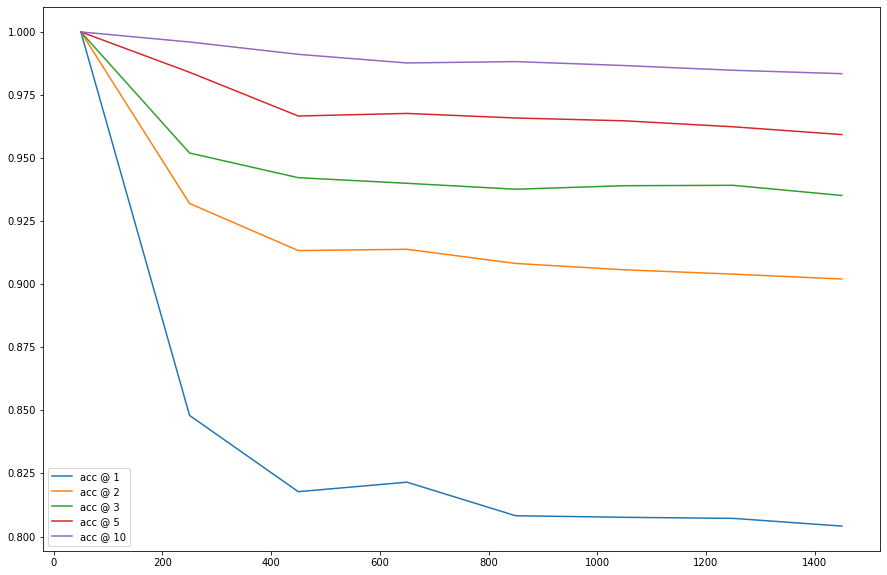

In [26]:
plt.figure(figsize=(15,10))
plt.plot(*zip(*acc1))
plt.plot(*zip(*acc2))
plt.plot(*zip(*acc3))
plt.plot(*zip(*acc5))
plt.plot(*zip(*acc10))
plt.legend([f'acc @ {x}' for x in [1,2,3,5,10]])

In [27]:
#export
@patch_to(LMLearner)
def print_synonyms(self, start_idx, n):
    data = self.model[0].encoder.p.data.argsort(descending=True)[:, :5]
    print('actual word\t\tpredictions\n')
    for i in range(start_idx, start_idx+n):
        print(f'{self.dbunch.vocab[i]}\t\t{[self.dbunch.vocab[idx] for idx in data[i]]}')

In [ ]:
learn.print_synonyms(60, 20)